# Minimize input model

This notebook can experiment with the input data. such as training only on the sequence, energy terms, or remove some of the sequences such as mhc or peptide

### Load Libraries

In [1]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from torch import nn, optim, cuda
from torch.utils.data.dataloader import DataLoader
from utils import Runner, EarlyStopping, TcrDataset, setup_seed
from network import Test
import pandas as pd

Set general plotting parameters for matplotlib using seaborn

In [2]:
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params, palette="pastel")

### General parameters

In [3]:
# General parameters
data_dir = "../../data/"
data_files = [data_dir+f"datasets/P{i}_input_cdrs.npz" for i in range(1,6)]
label_files = [data_dir+f"datasets/P{i}_labels.npz" for i in range(1,6)]

batch_size = 64
seed= 123

setup_seed(seed)
device = torch.device("cuda" if cuda.is_available() else "cpu")
#device= torch.device("cpu")

## Define indexing

In [4]:

########### Select Indexes TCR DATA ############

# Full model
#idx = np.arange(420)

# peptide + TCR
#idx = np.arange(179,420)

# MHC + TCR
#idx = np.concatenate([np.arange(179),np.arange(192,420)])

# TCR
#idx = np.arange(192,420)

# MHC + peptide
#idx = np.arange(192)


########### Select Indexes CDR Data ############

# Full model
# idx = np.arange(248)

# Peptide + All CDRS
idx = np.arange(179,248)

# peptide + cd

########### Select Features ###########

# All features
local_features = np.arange(27)
global_features = np.arange(27, 54)
use_global_features = True

# Sequence
#local_features = np.arange(20)
#global_features = None
#use_global_features = False

# Energy terms
#local_features = np.arange(20, 27)
#global_features = np.arange(27, 54)
#use_global_features = True

# Sequence and global energy
#local_features = np.arange(20)
#global_features = np.arange(27, 54)
#use_global_features = True

net = Test(local_features, global_features, use_global_features)
net.to(device)
print(net)
print("Using Device:", device)


Test(
  (conv1): Conv1d(27, 100, kernel_size=(3,), stride=(2,), padding=(1,))
  (conv2): Conv1d(100, 100, kernel_size=(3,), stride=(2,), padding=(1,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (rnn1): LSTM(100, 50, batch_first=True, bidirectional=True)
  (dense1): Linear(in_features=127, out_features=60, bias=True)
  (dense2): Linear(in_features=60, out_features=60, bias=True)
  (dense3): Linear(in_features=60, out_features=1, bias=True)
  (bn_start): BatchNorm1d(27, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn_cnn1): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn_cnn2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn_dense): BatchNorm1d(127, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop): Dropout(p=0.5, inplace=False)
  (heavy_drop): Dropout(p=0.7, inplace=False)
)
Using Device: cpu


## Load Data
Partitions can be changed by altering the `data_files` and `label_files` indexing

In [5]:
train_data = TcrDataset(data_files[0], label_files[0])
train_data.add_partition(data_files[1], label_files[1])
train_data.add_partition(data_files[2], label_files[2])
val_data = TcrDataset(data_files[3], label_files[3])
test_data = TcrDataset(data_files[4], label_files[4])

# Shuffle data randomly is needed
train_data.shuffle_data()
val_data.shuffle_data()
test_data.shuffle_data()

# slicing sequence dimension
train_data.slice_data(idx)
val_data.slice_data(idx)
test_data.slice_data(idx)


In [6]:
train_dl = DataLoader(train_data, batch_size)
val_dl = DataLoader(val_data, batch_size)
test_dl = DataLoader(test_data, batch_size)

In [7]:
len(train_data), len(val_data), len(test_data)

(4174, 1532, 1207)

In [8]:
train_data.data.shape

(4174, 54, 69)

In [9]:
#Hyperparameters
epochs = 100
patience = 15
lr = 0.005
loss_weight = sum(train_data.labels) / len(train_data.labels)
model_name = "minimize_input.pt"


# Loss and optimizer
criterion = nn.BCELoss(reduction='none')
optimizer = optim.Adam(net.parameters(), lr=lr,
    weight_decay=0.0005,
    amsgrad=True
)

stopper = EarlyStopping(patience, model_name)
# Define runners
train_runner = Runner(train_dl, net, criterion, loss_weight, device, optimizer)
val_runner = Runner(val_dl, net, criterion, loss_weight, device)
test_runner = Runner(test_dl, net, criterion, loss_weight, device)

## Training Loop

In [10]:
train_loss, val_loss, train_auc, val_auc = [], [], [], []

for epoch in range(1, epochs+1):
    train_runner.run_epoch()
    val_runner.run_epoch()
    
    train_runner.follow_performance(epoch)
    val_runner.follow_performance(epoch)
    stopper.evaluate_epoch(val_runner.loss, net, epoch)
    
    train_loss.append(train_runner.loss)
    val_loss.append(val_runner.loss)
    train_auc.append(train_runner.auc)
    val_auc.append(val_runner.auc)
    
    train_runner.reset()
    val_runner.reset()

    if stopper.stop:
        break


Epoch: 1
Train loss: 0.4458048271410393 Train MCC: -0.0014300558564435452 Train AUC: 0.5014712533368633
Validation loss: 0.26090774933497113 Validation MCC: -0.05029188806044013 Validation AUC: 0.5362865200071807
Validation loss decreased. Counter reset


/Users/christianjohansen/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Epoch: 2
Train loss: 0.28056185173265863 Train MCC: 0.023725134054518746 Train AUC: 0.5094369801663468
Validation loss: 0.26072146495183307 Validation MCC: 0.0 Validation AUC: 0.5351969131973086
Validation loss decreased. Counter reset
Epoch: 3
Train loss: 0.2629970492738666 Train MCC: 0.06897251399133532 Train AUC: 0.5440767766575232
Validation loss: 0.2597188949584961 Validation MCC: 0.02087414303617165 Validation AUC: 0.705223295543633
Validation loss decreased. Counter reset
Epoch: 4
Train loss: 0.25747541947798297 Train MCC: 0.09460117848735244 Train AUC: 0.5781212081099565
Validation loss: 0.25677671035130817 Validation MCC: -0.048617066691427784 Validation AUC: 0.7157046540640402
Validation loss decreased. Counter reset
Epoch: 5
Train loss: 0.25409146511193476 Train MCC: 0.13545941148589577 Train AUC: 0.6080233635581442
Validation loss: 0.24930582443873087 Validation MCC: 0.05600033648435501 Validation AUC: 0.7273983279818754
Validation loss decreased. Counter reset
Epoch: 6
Tra

(Text(0.5, 0, 'Epoch'), Text(0, 0.5, 'Loss'))

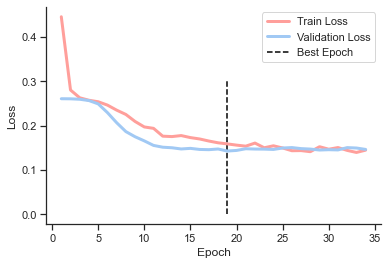

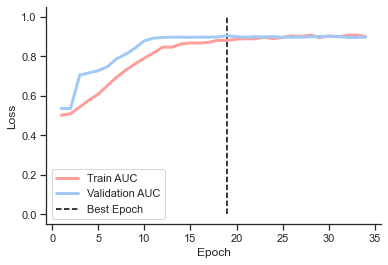

In [11]:
# Plots of training epochs
epoch = np.arange(1, len(train_loss) + 1)
plt.figure()
plt.plot(epoch, train_loss, "r", epoch, val_loss, "b", linewidth=3)
plt.vlines(stopper.best_epoch, ymin=0, ymax=0.3, colors="black", linestyles='dashed')
plt.legend(["Train Loss", "Validation Loss", "Best Epoch"])
plt.xlabel("Epoch"), plt.ylabel("Loss")

epoch = np.arange(1, len(train_loss) + 1)
plt.figure()
plt.plot(epoch, train_auc, "r", epoch, val_auc, "b", linewidth=3)
plt.vlines(stopper.best_epoch, ymin=0, ymax=1, colors="black", linestyles='dashed')
plt.legend(["Train AUC", "Validation AUC", "Best Epoch"])
plt.xlabel("Epoch"), plt.ylabel("Loss")

## Evaluate using the best model

Best model is stored as early_stopping_state.pt and loaded into a new object

In [12]:
final_model = Test(local_features, global_features, use_global_features)
final_model.load_state_dict(torch.load(model_name))
final_model.to(device)

train_runner.model = final_model
val_runner.model = final_model
test_runner.model = final_model

In [13]:
train_runner.reset()
val_runner.reset()
test_runner.reset()

train_runner.evaluation_mode() # Set to validation to avoid more training
train_runner.run_epoch()
val_runner.run_epoch()
test_runner.run_epoch()

Evaluation on Training Data:
Loss: 0.12836248224431818
MCC: 0.674045143439353
Confussion Matrix:
 [[2801  331]
 [ 203  839]] 

Evaluation on Validation Data:
Loss: 0.14296796917915344
MCC: 0.6069741360677549
Confussion Matrix:
 [[1013  136]
 [  98  285]] 

Evaluation on Test Data:
Loss: 0.16097851803428248
MCC: 0.5507618653166877
Confussion Matrix:
 [[794 112]
 [ 95 206]] 



Text(0.5, 1.0, 'Test Data')

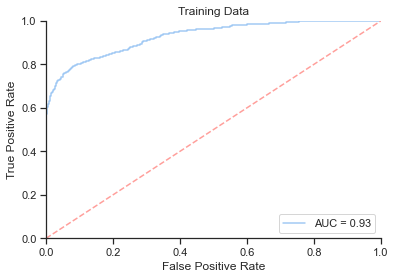

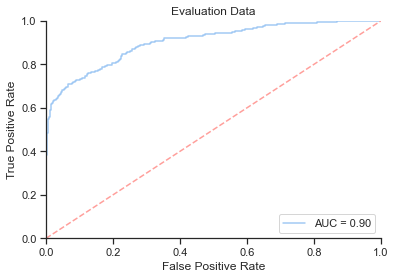

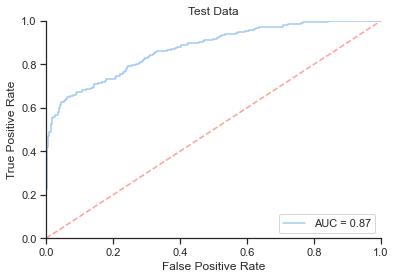

In [14]:
print("Evaluation on Training Data:")
train_runner.evaluate_model()
plt.title("Training Data")

print("Evaluation on Validation Data:")
val_runner.evaluate_model()
plt.title("Evaluation Data")

print("Evaluation on Test Data:")
test_runner.evaluate_model()
plt.title("Test Data")


In [13]:
arrays=[np.array(["all_feat", "all_feat", "all_feat", "all_feat", "all_feat",
       "sequence", "sequence", "sequence", "sequence", "sequence",
       "energy_terms", "energy_terms", "energy_terms", "energy_terms", "energy_terms",
       "seq_globalenergy", "seq_globalenergy", "seq_globalenergy", "seq_globalenergy", "seq_globalenergy"])
       ,
       np.array(["full_model", "peptide_tcr", "mhc_tcr", "tcr", "peptide_mhc",
       "full_model", "peptide_tcr", "mhc_tcr", "tcr", "peptide_mhc",
       "full_model", "peptide_tcr", "mhc_tcr", "tcr", "peptide_mhc",
       "full_model", "peptide_tcr", "mhc_tcr", "tcr", "peptide_mhc"])]

results= pd.DataFrame({"auc_train" : [0.95, 0.96, 0.91, 0.88, 0.60, 0.92, 0.95, 0.77, 0.76, 0.60, 0.94, 0.94, 0.93, 0.92, 0.88, 0.95, 0.94, 0.78, 0.77, 0.70],
                       "auc_val" : [0.91, 0.91, 0.84, 0.79, 0.62, 0.90, 0.90, 0.72, 0.73, 0.61, 0.87, 0.89, 0.85, 0.79, 0.82, 0.89, 0.90, 0.73, 0.72, 0.71],
                       "auc_test" : [0.86, 0.86, 0.78, 0.76, 0.54, 0.87, 0.87, 0.70, 0.70, 0.57, 0.83, 0.85, 0.81, 0.74, 0.78, 0.85, 0.87, 0.70, 0.70, 0.63],
                       "mcc_train" : [0.75, 0.70, 0.69, 0.55, 0.095, 0.63, 0.61, 0.36, 0.37, 0.18, 0.72, 0.61, 0.67, 0.62, 0.62, 0.72, 0.60, 0.38, 0.39, 0.00228],
                       "mcc_val" : [0.63, 0.56, 0.58, 0.45, 0.14, 0.54, 0.55, 0.32, 0.32, 0.18, 0.58, 0.51, 0.57, 0.44, 0.54, 0.65, 0.52, 0.33, 0.32, 0.00223], 
                       "mcc_test" : [0.54, 0.52, 0.51, 0.41, 0.047, 0.49, 0.47, 0.31, 0.31, 0.12, 0.52, 0.47, 0.53, 0.37, 0.49, 0.59, 0.49, 0.31, 0.30, 0.00169]}, index=arrays)
results

auc_train  auc_val  auc_test  mcc_train  \
all_feat         full_model        0.95     0.91      0.86    0.75000   
                 peptide_tcr       0.96     0.91      0.86    0.70000   
                 mhc_tcr           0.91     0.84      0.78    0.69000   
                 tcr               0.88     0.79      0.76    0.55000   
                 peptide_mhc       0.60     0.62      0.54    0.09500   
sequence         full_model        0.92     0.90      0.87    0.63000   
                 peptide_tcr       0.95     0.90      0.87    0.61000   
                 mhc_tcr           0.77     0.72      0.70    0.36000   
                 tcr               0.76     0.73      0.70    0.37000   
                 peptide_mhc       0.60     0.61      0.57    0.18000   
energy_terms     full_model        0.94     0.87      0.83    0.72000   
                 peptide_tcr       0.94     0.89      0.85    0.61000   
                 mhc_tcr           0.93     0.85      0.81    0.67000   
                 tcr               0.92     0.79      0.74    0.62000   
                 peptide_mhc       0.88     0.82      0.78    0.62000   
seq_globalenergy full_model        0.95     0.89      0.85    0.72000   
                 peptide_tcr       0.94     0.90      0.87    0.60000   
                 mhc_tcr           0.78     0.73      0.70    0.38000   
                 tcr               0.77     0.72      0.70    0.39000   
                 peptide_mhc       0.70     0.71      0.63    0.00228   

                              mcc_val  mcc_test  
all_feat         full_model   0.63000   0.54000  
                 peptide_tcr  0.56000   0.52000  
                 mhc_tcr      0.58000   0.51000  
                 tcr          0.45000   0.41000  
                 peptide_mhc  0.14000   0.04700  
sequence         full_model   0.54000   0.49000  
                 peptide_tcr  0.55000   0.47000  
                 mhc_tcr      0.32000   0.31000  
                 tcr          0.32000   0.31000  
                 peptide_mhc  0.18000   0.12000  
energy_terms     full_model   0.58000   0.52000  
                 peptide_tcr  0.51000   0.47000  
                 mhc_tcr      0.57000   0.53000  
                 tcr          0.44000   0.37000  
                 peptide_mhc  0.54000   0.49000  
seq_globalenergy full_model   0.65000   0.59000  
                 peptide_tcr  0.52000   0.49000  
                 mhc_tcr      0.33000   0.31000  
                 tcr          0.32000   0.30000  
                 peptide_mhc  0.00223   0.00169

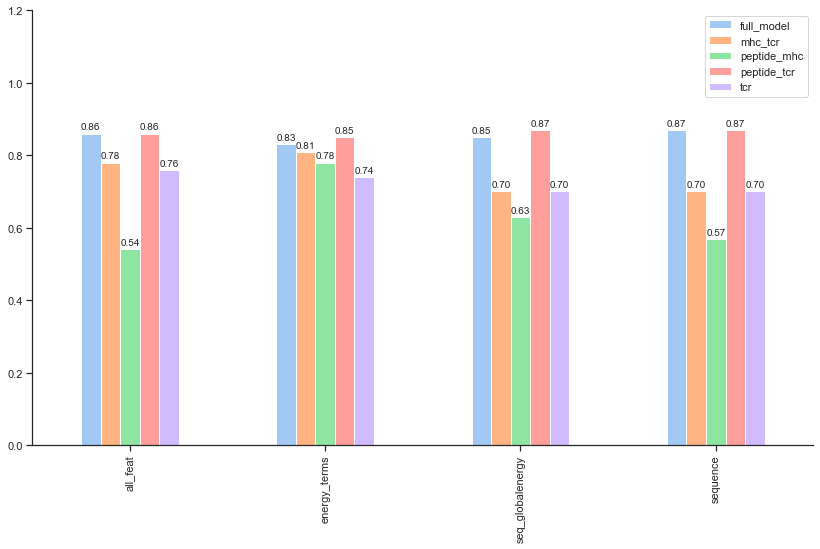

In [75]:
plt.figure(figsize=(14,8))
ax = plt.gca()
results["auc_test"].unstack().plot(kind='bar', ax=ax, ylim=(0,1.2))
for container in ax.containers:
    ax.bar_label(container, padding=2, fmt="%.2f", fontsize=10)


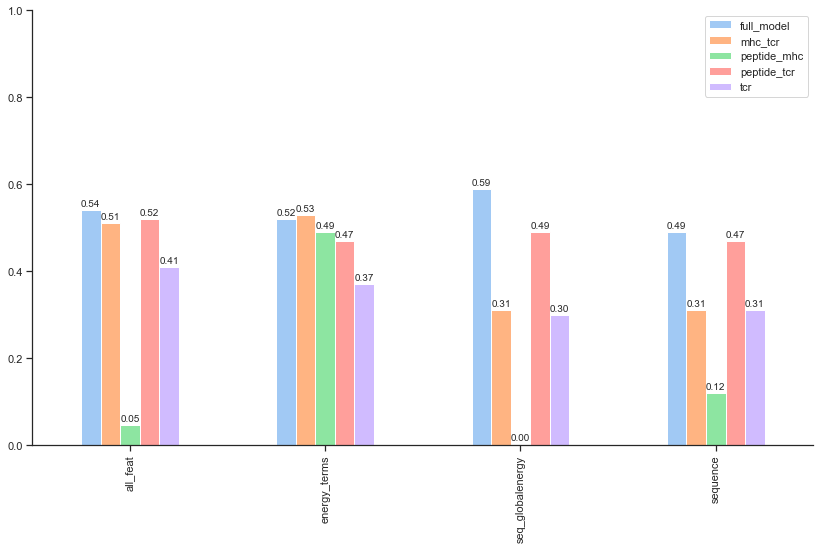

In [74]:
plt.figure(figsize=(14,8))
ax = plt.gca()
results["mcc_test"].unstack().plot(kind='bar', ax=ax, ylim=(0,1))
for container in ax.containers:
    ax.bar_label(container, padding=2, fmt="%.2f", fontsize=10)